# Install dependencies

In [0]:
%%shell
sudo apt-get install tesseract-ocr tesseract-ocr-por
sudo apt-get install -y libsm6 libxext6 libxrender-dev
sudo apt-get install -y poppler-utils
pip install natas 
python -m natas.download
#python -m spacy download pt_core_news_sm
#python -m spacy download en_core_web_md
python -m spacy download pt
pip install pytesseract
pip install pdf2image

#Imports

In [0]:
!python -m spacy download en_core_web_md

In [0]:
from pdf2image import convert_from_bytes, convert_from_path
import pytesseract
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import spacy
import natas
import re
from google.colab import files
nlp = spacy.load('en_core_web_md') # Caso dê erro ao carregar a biblioteca é só utilizar as teclas CTRL+M para reiniciar o runtime
#nlp = spacy.load('pt')


# Functions

In [0]:
def binarization(image):
    """

    Função que aplica a finarização na imagem.

    Parameters
    ----------
    image : PIL.Image.Image
        Imagem para ser binarizada.

    Returns
    -------
    PIL.Image.Image
        Imagem binarizada.
    """ 
    image = image.convert('RGB')
    npimage = np.asarray(image).astype(np.uint8)  
    npimage[:, :, 0] = 0
    npimage[:, :, 2] = 0
    im = cv2.cvtColor(npimage, cv2.COLOR_RGB2GRAY) 
    ret, thresh = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) 
    binimage = Image.fromarray(thresh) 
    return binimage

def get_pages_as_images(file):
    """

    Percorre as paginas do PDF convertendo-o em imagem e realizando a binarização
    
    Parameters
    ----------
    file : bytes
        Documento em `bytes` contendo o `PDF`.

    Returns
    -------
    PIL.Image.Image
        Documento transformado em imagem e binarizada.
    """ 
    images = convert_from_bytes(file, 250, grayscale=True)
    num_page = 1
    for image in images:
        left = image.size[0]*0.05
        right = image.size[0]*0.95
        top = image.size[1]*0.05
        bottom = image.size[1]*0.95
        image = image.crop((left, top, right,bottom))
        image = binarization(image)
    return images

def get_ocr_documents(images):
    """

    Percorre as imagens do PDF `lendo-as` com o pytesseract convertendo 
    imagem em `string`.
    
    Parameters
    ----------
    images : PIL.Image.Image
        Imagens, resultados da conversão do PDF.

    Returns
    -------
    String
        Um texto contendo todas as leituras das paginas
    """ 
    
    pages_text = []
    for image in images:
      #https://stackoverflow.com/questions/44619077/pytesseract-ocr-multiple-config-options
      pages_text.append(pytesseract.image_to_string(image, config='--psm 4' ,lang='eng'))
    return ''.join(pages_text)

def is_number(s):
    """

    Verifica se a variavel é um número
    
    Parameters
    ----------
    image : int
        The first parameter.

    Returns
    -------
    bool
        Verdadeiro caso o cast ocorra. Falso caso contrário.
    """ 
    try:
        float(s)
        return True
    except ValueError:
        return False

# Upload PDF

In [0]:
# Realiza o upload do documento para o colabs
uploaded = files.upload()

Saving Applied Dynamic Programming.pdf to Applied Dynamic Programming.pdf


In [0]:
for k in uploaded.keys():
  pdf = uploaded[k]

Applied Dynamic Programming.pdf


#OCR

## Extract Text 

### Apenas imagens

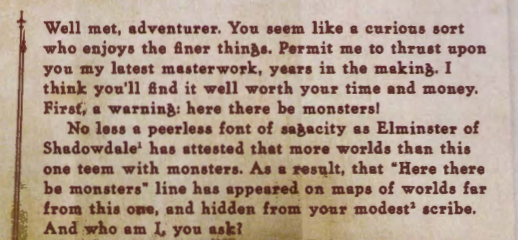

In [0]:
# Lê a imagem com o opencv e envia diretamente para a ocr.
# Cuidado que a imagem não sobre qualquer tipo de processamento,
# pois isto é feito ao ler o documento.
source = "/content/asd2.PNG"
images = cv2.imread(source)
cv2_imshow(images)
pages_text = get_ocr_documents([images])

###PDF

In [0]:
images = get_pages_as_images(pdf)  # Transforma em imagem
pages_text = get_ocr_documents(images) # Transforma em texto

### Print Text

In [0]:
print(pages_text) # Visualização do documento `transcrito`

#Post-processing

##Pretrained model for OCR post correction

### Clear text

In [0]:
new_pages = pages_text.replace("\n"," ") # remove \n from the text. 
new_pages = re.sub('[^A-Za-z0-9]+', ' ', new_pages) # mantem apenas elementos alfa-numercos no documento

### Split text

In [0]:
seed_words = new_pages.split(" ") # "Tokeniza" o documento

###Check if a word is correctly spelled and replace then

In [0]:
"""
Cria uma lista de correcoes
Percorre os tokens seed_words:
  Se não estiver no dicionario e não for um número:
    Tenta:
      Encontrar as 20 melhores correções 
    Caso erro:
      Encontrar as 10 melhores correções 
    Se a lista de sugestão não estiver vazia:
       Adiciona a primeira sugestao em correcoes
    Caso contrario:
       Adiciona o token que esta sendo analisado nas correcoes
  Senão se o token em analise não for nulo e invalida os casos do if anterior:
    Adiciona o token em questão nas correcoes
"""

corrected = []
for i in seed_words:
  if not natas.is_correctly_spelled(i) and not is_number(i) and i:
    try:
      sug = natas.ocr_correct_words([i], n_best = 20)[0]
    except:
      sug = natas.ocr_correct_words([i], n_best = 10)[0]
    print("Palavra errada: ", i)
    print("Sugestão: ",sug)
    print("---------")
    if sug:
      corrected.append(sug[0])
    else:
      corrected.append(i)
  elif i:
    corrected.append(i)

### Print Text corrected

In [0]:
corrected

### Atividade



1.   Criar um novo dicionario de palavras utilizando o napas
2.   Checar se nova palavra existe
3.   Modificar o dicionario
4.   Enriquecer o dicionário de palavras complementando com as 10 palavras mais próximas em um word embedding

